In [8]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


Define the slow manifold class

In [12]:
class SlowManifold():   
    def __init__(self, model_name, data_dir):
        """
        Initializes the SlowManifold class.
        
        Args:
            model_name (str): The name of the slow manifold model to load.
            data_dir (str): Directory path where the model files are stored.
            speedup_rate (float): The rate of speedup relative to the existing trajectory.
            reference_trajectory 
        """
        self.model_name = model_name
        self.data_dir = data_dir
        self._load_slow_model()

    def phi(self, xi, exps):
            """ Returns monomials for slow manifold.
            Args: 
                xi: Input array of shape (n_dimensions,) of positions
                exps: Exponent matrix of shape (n_monomials, n_dimensions). 
            Returns:
                monomials: Monomial matrix of shape (n_monomials). """ 
            #self.get_logger().info(f"exps: {exps.shape}")
            x = np.reshape(xi, (1,-1)) # reshaped to dim (n_dimensions,1)
            #self.get_logger().info(f"x: {x.shape}")
            x_expanded = np.tile(x, (exps.shape[0], 1)) #repeat for each monomial (n_monomials, n_dimensions)
            #self.get_logger().info(f"x_expanded: {x_expanded.shape}")
            monomials = np.prod(x_expanded**exps, axis=1) 
            return monomials

    def _load_slow_model(self):
        "Loads model for slow manifold predictions"
        model_path = os.path.join(self.data_dir, f'models/ssm/{self.model_name}.npz')

        # Load the model
        self.model = np.load(model_path)

        self.decoder_exp = np.array(self.model['decoder_exp'])
        self.const_coeff = np.array(self.model['Const_coeff'])
        self.decoder_coeff = np.array(self.model['decoder_coeff'])
        print('Loaded slow manifold model')


    def slow_manifold_callback(self, request):
        """
        Callback function that runs when the service is queried.
        Request contains: z (desired performance variable trajectory)
        Response contains: uopt (the found control inputs)
        """
        # decoder_exp shape = (83, 6)
        # const_coeff shape = (6, 1)
        # decoder_coeff shape = (6, 83)
        zf_des = np.array(request) # desired positions
        # self.get_logger().info(f"zf_des (zero centered from AVP) {zf_des}")
        # zf_des += self.rest_positions # It is already zero centered straight from the AVP... so we need to offset away from zero into the frame we learned the model in
        # self.get_logger().info(f"offset zf_des: {zf_des}")

        monomials = self.phi(zf_des, self.decoder_exp)
        u = (self.decoder_coeff @ monomials).reshape(self.const_coeff.shape[0], 1)

        self.const_coeff = self.const_coeff.reshape(self.const_coeff.shape[0],1)
        u_opt = u + self.const_coeff # add constant coefficients
        #self.get_logger().info(f"u_opt {u_opt}")

        # check control inputs are within the workspace
        u_opt = self.check_control_inputs(u_opt.flatten())
        response = u_opt.tolist()

        return response
    
    def check_control_inputs(self, u_opt):
        # reject vector norms of u that are too large
        tip_range, mid_range, base_range = 0.45, 0.35, 0.3 

        u1, u2, u3, u4, u5, u6 = u_opt[0], u_opt[1], u_opt[2], u_opt[3], u_opt[4], u_opt[5]

        # First we clip to max and min values
        u1 = np.clip(u1, -tip_range, tip_range)
        u6 = np.clip(u6, -tip_range, tip_range)
        u2 = np.clip(u2, -mid_range, mid_range)
        u5 = np.clip(u5, -mid_range, mid_range)
        u3 = np.clip(u3, -base_range, base_range)
        u4 = np.clip(u4, -base_range, base_range)

        # Compute control input vectors
        u1_vec = u1 * np.array([-np.cos(15 * np.pi/180), np.sin(15 * np.pi/180)])
        u2_vec = u2 * np.array([np.cos(45 * np.pi/180), np.sin(45 * np.pi/180)])
        u3_vec = u3 * np.array([-np.cos(15 * np.pi/180), -np.sin(15 * np.pi/180)])
        u4_vec = u4 * np.array([-np.cos(75 * np.pi/180), np.sin(75 * np.pi/180)])
        u5_vec = u5 * np.array([np.cos(45 * np.pi/180), -np.sin(45 * np.pi/180)])
        u6_vec = u6 * np.array([-np.cos(75 * np.pi/180), -np.sin(75 * np.pi/180)])

        # Calculate the norm based on the constraint
        vector_sum = (
            0.75 * (u3_vec + u4_vec) +
            1.0 * (u2_vec + u5_vec) +
            1.4 * (u1_vec + u6_vec)
        )
        norm_value = np.linalg.norm(vector_sum)

        # Check the constraint: if the constraint is met, then keep previous control command
        if norm_value > 0.9:
            u_opt = self.u_opt_previous
        else:
            # Else the clipped command is published
            u_opt = np.array([u1, u2, u3, u4, u5, u6])

        return u_opt

In [13]:
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

Load the slow manifold model and create control inputs it given a reference trajectory

In [15]:
data_dir='/home/trunk/Documents/trunk-stack/stack/main/data'
# on mark's mac  data_dir = /Users/markleone/Documents/Stanford/ASL/trunk-stack/stack/main/data
# on linux machine: data_dir = '/home/trunk/Documents/trunk-stack/stack/main/data'

In [17]:
model_name = "slow_manifold"

# load the slow manifold
slow_manifold = SlowManifold(
    model_name=model_name, 
    data_dir=data_dir
)

# load the reference trajectory
ref_traj_name = 'trajectories/dynamic/observations_controlled_circle_7.0_ext.csv'
ref_traj_path =  os.path.join(data_dir, ref_traj_name)
ys_ref = pd.read_csv(ref_traj_path)

control_inputs = []

for idx, row in ys_ref.iterrows():
    zf_des = np.array([row['x2'], row['y2'], row['z2'], row['x3'], row['y3'], row['z3']]) # Extract the observables of interest
    result = slow_manifold.slow_manifold_callback(zf_des) # run callback
    control_inputs.append([idx] + result)  # store control inputs

# Convert the control inputs to a DataFrame
control_inputs_df = pd.DataFrame(control_inputs, columns=['ID', 'u1', 'u2', 'u3', 'u4', 'u5', 'u6'])

# Save the results to a CSV file
output_file = os.path.join(data_dir, 'trajectories/dynamic/control_inputs_slow_manifold_ext.csv')
control_inputs_df.to_csv(output_file, index=False)

print(f"Control inputs saved to {output_file}")



Loaded slow manifold model
Control inputs saved to /home/trunk/Documents/trunk-stack/stack/main/data/trajectories/dynamic/control_inputs_slow_manifold_ext.csv


Smooth the reference trajectory to generate (hopefully) better control inputs with slow manifold

In [18]:
model_name = "slow_manifold"

# load the slow manifold
slow_manifold = SlowManifold(
    model_name=model_name, 
    data_dir=data_dir
)

# load the reference trajectory
ref_traj_name = 'trajectories/dynamic/observations_controlled_circle_7.0_ext.csv'
ref_traj_path =  os.path.join(data_dir, ref_traj_name)
ys_ref = pd.read_csv(ref_traj_path)

ys_ref = np.array(ys_ref)
window_size = 50 # in 1/100s
smooth_ys_ref = np.apply_along_axis(
        lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='valid'),
        axis=0,
        arr=ys_ref
    ) # smooth with moving average filter

print(ys_ref.shape)
print(ys_ref[1])

control_inputs = []

idx = 0
for row in smooth_ys_ref:
    zf_des = np.array([row[4], row[5], row[6], row[7], row[8], row[9]]) # Extract the observables of interest
    result = slow_manifold.slow_manifold_callback(zf_des) # run callback
    control_inputs.append([idx] + result)  # store control inputs
    idx += 1

# Convert the control inputs to a DataFrame
control_inputs_df = pd.DataFrame(control_inputs, columns=['ID', 'u1', 'u2', 'u3', 'u4', 'u5', 'u6'])

# Save the results to a CSV file
output_file = os.path.join(data_dir, 'trajectories/dynamic/control_inputs_slow_manifold_ext_smoothed.csv')
control_inputs_df.to_csv(output_file, index=False)

print(f"Control inputs saved to {output_file}")



Loaded slow manifold model
(1400, 16)
[  1.           0.10041177  -0.10718524   0.10548361   0.10345706
  -0.20530662   0.112144     0.10926545  -0.32407278   0.10981133
 -88.          -7.          68.         -74.          58.
 -23.        ]
Control inputs saved to /home/trunk/Documents/trunk-stack/stack/main/data/trajectories/dynamic/control_inputs_slow_manifold_ext_smoothed.csv


Check the control inputs that slow manifold predicts vs the actual control inputs we originally used to collect the reference trajectory

In [21]:
us_ref_path = os.path.join(data_dir, 'trajectories/dynamic/control_inputs_controlled_circle_2_ext.csv')
us_ref = pd.read_csv(us_ref_path)

us_pred_path = os.path.join(data_dir, 'trajectories/dynamic/control_inputs_slow_manifold_ext.csv')
us_pred = pd.read_csv(us_pred_path)

us_smooth_path = os.path.join(data_dir, 'trajectories/dynamic/control_inputs_slow_manifold_ext_smoothed.csv')
us_smooth = pd.read_csv(us_smooth_path)

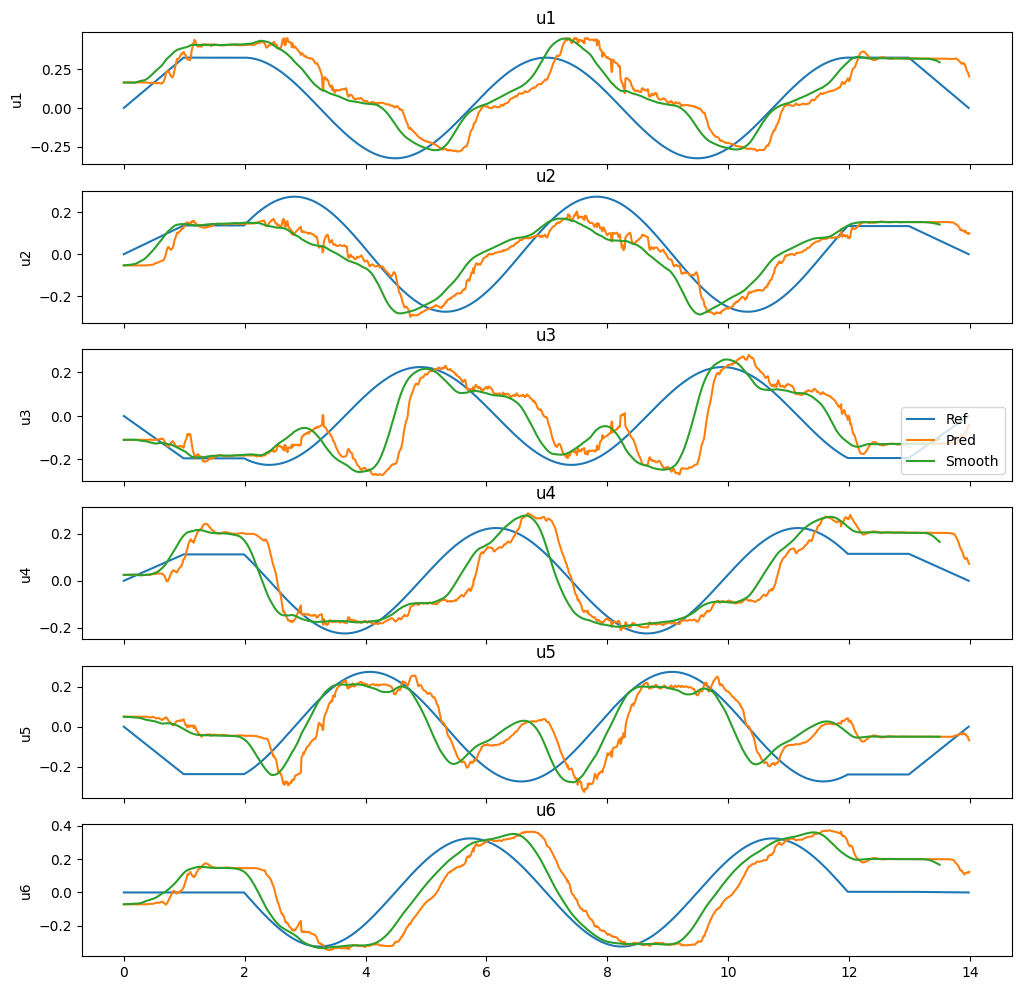

In [22]:
fig, axs = plt.subplots(6, 1, figsize=(12,12), sharex=True)
time = us_ref['ID']/100 # time in s
time_pred = us_pred['ID']/100
time_smooth = us_smooth['ID']/100

# Plot u1
axs[0].plot(time, us_ref['u1'], label='Ref')
axs[0].plot(time_pred, us_pred['u1'], label='Pred')
axs[0].plot(time_smooth, us_smooth['u1'], label='Smooth')
axs[0].set_title("u1")
axs[0].set_ylabel("u1")

# Plot u2
axs[1].plot(time, us_ref['u2'], label='Ref')
axs[1].plot(time_pred, us_pred['u2'], label='Pred')
axs[1].plot(time_smooth, us_smooth['u2'], label='Smooth')
axs[1].set_title("u2")
axs[1].set_ylabel("u2")

# Plot u3
axs[2].plot(time, us_ref['u3'], label='Ref')
axs[2].plot(time_pred, us_pred['u3'], label='Pred')
axs[2].plot(time_smooth, us_smooth['u3'], label='Smooth')
axs[2].set_title("u3")
axs[2].set_ylabel("u3")

# Plot u4
axs[3].plot(time, us_ref['u4'], label='Ref')
axs[3].plot(time_pred, us_pred['u4'], label='Pred')
axs[3].plot(time_smooth, us_smooth['u4'], label='Smooth')
axs[3].set_title("u4")
axs[3].set_ylabel("u4")

# Plot u5
axs[4].plot(time, us_ref['u5'], label='Ref')
axs[4].plot(time_pred, us_pred['u5'], label='Pred')
axs[4].plot(time_smooth, us_smooth['u5'], label='Smooth')
axs[4].set_title("u5")
axs[4].set_ylabel("u5")

# Plot u6
axs[5].plot(time, us_ref['u6'], label='Ref')
axs[5].plot(time_pred, us_pred['u6'], label='Pred')
axs[5].plot(time_smooth, us_smooth['u6'], label='Smooth')
axs[5].set_title("u6")
axs[5].set_ylabel("u6")



axs[2].legend(loc="lower right")

Check slow manifold tracking performance

In [23]:
rest_positions = np.array([0.10056, -0.10541, 0.10350, 0.09808, -0.20127, 0.10645, 0.09242, -0.31915, 0.09713])
ys_ik = pd.read_csv(f'../data/trajectories/dynamic/observations_controlled_circle_7.0_ext.csv')
ys_ik_2 = pd.read_csv(f'../data/trajectories/dynamic/observations_slow_manifold_ext_test_1.csv')

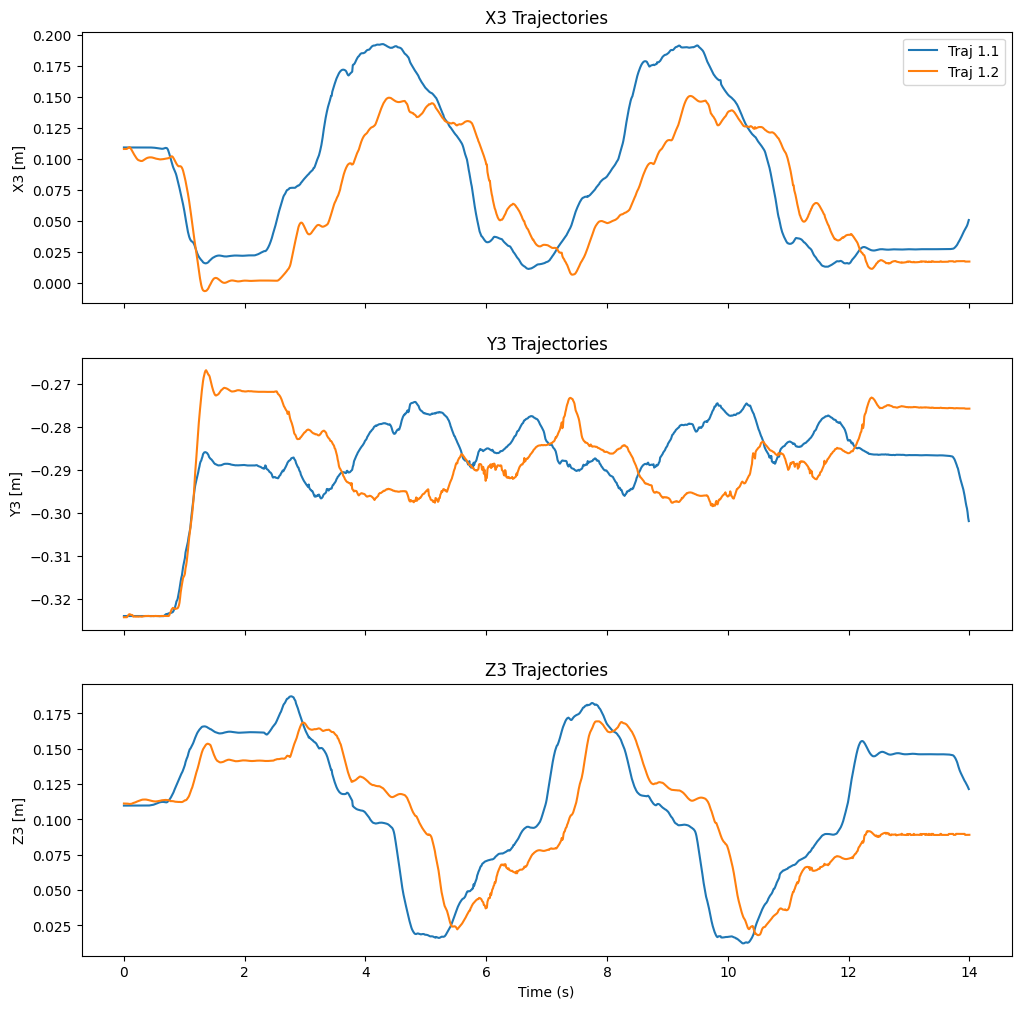

In [24]:
fig, axs = plt.subplots(3, 1, figsize=(12,12), sharex=True)
time = ys_ik['ID']/100 # time in s
time_2 = ys_ik_2['ID']/100

# Plot x3
axs[0].plot(time, ys_ik['x3'], label='Traj 1.1')
axs[0].plot(time_2, ys_ik_2['x3'], label='Traj 1.2')
axs[0].set_title("X3 Trajectories")
axs[0].set_ylabel("X3 [m]")

# Plot y3
axs[1].plot(time, ys_ik['y3'], label='Traj 1.1')
axs[1].plot(time_2, ys_ik_2['y3'], label='Traj 1.2')
axs[1].set_title("Y3 Trajectories")
axs[1].set_ylabel("Y3 [m]")

# Plot z3
axs[2].plot(time, ys_ik['z3'], label='Traj 1.1')
axs[2].plot(time_2, ys_ik_2['z3'], label='Traj 1.2')
axs[2].set_title("Z3 Trajectories")
axs[2].set_ylabel("Z3 [m]")
axs[2].set_xlabel("Time (s)")


axs[0].legend(loc="upper right")

Plot trajectories in 3d

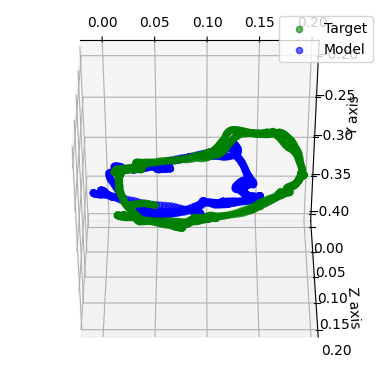

In [25]:
plt.close('all')

# Enable the ipympl backend for interactive plots
#%matplotlib widget

z_dataframes = [ys_ik]
z_model = [ys_ik_2]
position_colors = ['r', 'b', 'g']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for z_df in z_dataframes:
    # x1, y1, z1 = z_df['x1'], z_df['y1'], z_df['z1']
    # x2, y2, z2 = z_df['x2'], z_df['y2'], z_df['z2']
    x3, y3, z3 = z_df['x3'], z_df['y3'], z_df['z3']
    # ax.scatter(x1, y1, z1, color=position_colors[0], label='Position 1', alpha=0.6)
    # ax.scatter(x2, y2, z2, color=position_colors[1], label='Position 2', alpha=0.6)
    ax.scatter(x3, y3, z3, color=position_colors[2], label='Target', alpha=0.6)

for z_df in z_model:
    x3, y3, z3 = z_df['x3'], z_df['y3'], z_df['z3']
    ax.scatter(x3, y3, z3, color=position_colors[1], label='Model', alpha=0.6)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
# Adjust the view so that y-axis is upwards
ax.view_init(elev=130, azim=-90)
ax.legend()
set_axes_equal(ax)

Generate smooth control inputs for making a slow reference trajectory for slow manifold testing with ramps and pauses

In [11]:
data_dir = '/home/trunk/Documents/trunk-stack/stack/main/data'
u_name = 'trajectories/dynamic/control_inputs_controlled_circle_2.csv'
u_path = os.path.join(data_dir, u_name)

# Load the reference control inputs
us = pd.read_csv(u_path)

# ramp and pause time parameters
ramp_time = 100  # number of steps for ramp-up/down (in 1/100 s)
pause_time = 100  # number of steps for pause (in 1/100 s)
n = len(us)

new_controls = []

# ramp from 0 to target value
def ramp_up(target, steps):
    return np.linspace(0, target, steps)

# ramp down to 0
def ramp_down(target, steps):
    return np.linspace(target, 0, steps)

# Generate new control inputs
for idx in range(n):
    # Step 1: Ramp up to the first control input
    if idx == 0:
        target_control = us.iloc[idx, 1:]  
        ramp_up_sequence = np.array([ramp_up(target_control[i], ramp_time) for i in range(6)]).T 
        
        # Step 2: Pause at the first control input
        pause_sequence = np.array([np.full(pause_time, target_control[i]) for i in range(6)]).T
        new_controls.append(np.vstack([ramp_up_sequence, pause_sequence])) 

    else: # Step 3: just append other control inputs to sequence
        target_control = us.iloc[idx, 1:] 
        new_controls.append(np.array([target_control]))

# Step 4+5: Pause and ramp down at the last control input
target_control = us.iloc[-1, 1:]  # Last control input
pause_sequence = np.array([np.full(pause_time, target_control[i]) for i in range(6)]).T
ramp_down_sequence = np.array([ramp_down(target_control[i], ramp_time) for i in range(6)]).T
new_controls.append(np.vstack([pause_sequence, ramp_down_sequence])) 

# create df
us_df = np.vstack(new_controls)
us_df = pd.DataFrame(us_df, columns=us.columns[1:]) 
us_df.insert(0, 'ID', np.arange(len(us_df)))

# save to a new csv
output_path = os.path.join(data_dir, 'trajectories/dynamic/control_inputs_controlled_circle_2_smooth.csv')
us_df.to_csv(output_path, index=False)

print(f"New control inputs have been saved to {output_path}")


New control inputs have been saved to /home/trunk/Documents/trunk-stack/stack/main/data/trajectories/dynamic/control_inputs_controlled_circle_2_smooth.csv


/tmp/ipykernel_537017/787177445.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ramp_up_sequence = np.array([ramp_up(target_control[i], ramp_time) for i in range(6)]).T
/tmp/ipykernel_537017/787177445.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pause_sequence = np.array([np.full(pause_time, target_control[i]) for i in range(6)]).T
/tmp/ipykernel_537017/787177445.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  paus